In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, kurtosis, shapiro

import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [4]:
# 데이터 로드
df_merged = pd.read_csv('df_merged.csv')

### 상호작용과 비선형성 분석 (새로운 변수 중심)

### 1. 엽록소 형광 변수들 - 이상치 판단 근거
- 자료조사 이 변수들 설명 x -> 추가 조사 필요
- 에너지 흐름을 나타내는 변수들
- ABS(흡수) -> Tro(포획) -> Eto(전달) -> Dio(소산)

In [5]:
# 1-1. 에너지 보존 법칙 확인
# 에너지 보존 검증 (ABS = Tro + Dio 예상)
df_merged['energy_sum'] = df_merged['Tro-RC'] + df_merged['Dio-RC']
df_merged['energy_diff'] = df_merged['ABS-RC'] - df_merged['energy_sum']

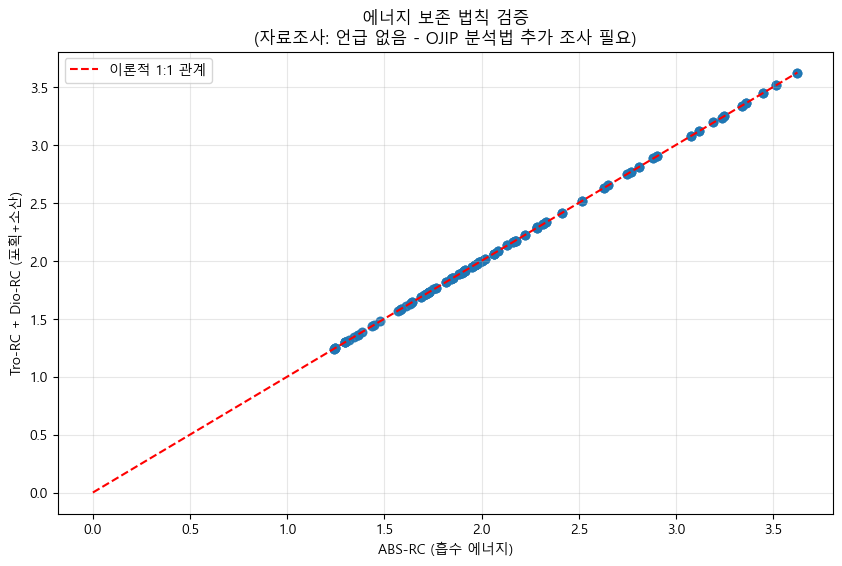

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(df_merged['ABS-RC'], df_merged['energy_sum'], alpha=0.5)
plt.plot([0, df_merged['ABS-RC'].max()], [0, df_merged['ABS-RC'].max()], 
         'r--', label='이론적 1:1 관계')
plt.xlabel('ABS-RC (흡수 에너지)')
plt.ylabel('Tro-RC + Dio-RC (포획+소산)')
plt.title('에너지 보존 법칙 검증\n(자료조사: 언급 없음 - OJIP 분석법 추가 조사 필요)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

- 에너지 보존 법칙 
- ABS = TRO + DIO -> 자료조사와 일치

In [7]:
energy_violation = df_merged[abs(df_merged['energy_diff']) > 1]
print(f"에너지 보존 위반 데이터: {len(energy_violation)}개")
if len(energy_violation) > 0:
    print("→ 이상치 가능성 높음 (물리법칙 위반)")
    print(energy_violation[['month', 'scenario', 'ABS-RC', 'Tro-RC', 'Dio-RC', 'energy_diff']].head())

에너지 보존 위반 데이터: 0개


In [8]:
# 1-2. Dio/ABS 비율 (스트레스 지표)
df_merged['dissipation_ratio'] = df_merged['Dio-RC'] / df_merged['ABS-RC']

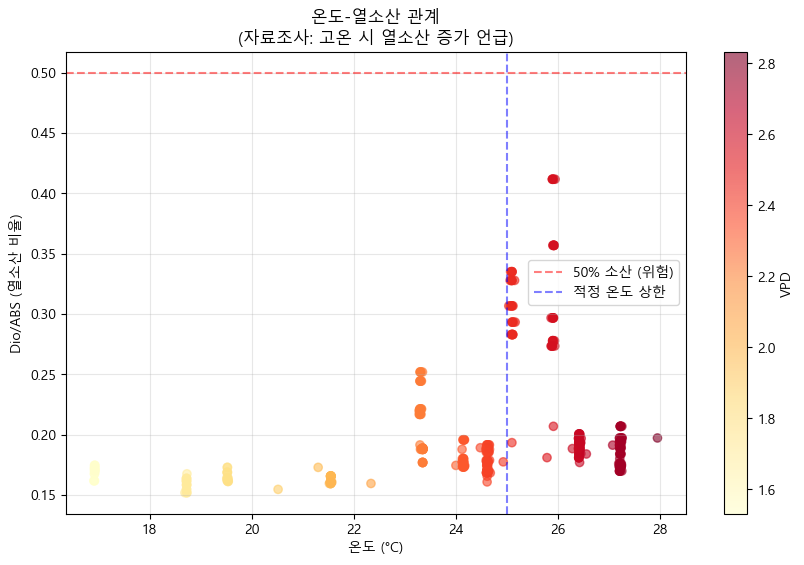

열소산 50% 이상: 0개
평균 온도: nan°C
→ 극한 스트레스 상태, 이상치 아님


In [9]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_merged['Temp'], df_merged['dissipation_ratio'], 
                     c=df_merged['VPD'], cmap='YlOrRd', alpha=0.6)
plt.xlabel('온도 (°C)')
plt.ylabel('Dio/ABS (열소산 비율)')
plt.title('온도-열소산 관계\n(자료조사: 고온 시 열소산 증가 언급)')
plt.colorbar(scatter, label='VPD')
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50% 소산 (위험)')
plt.axvline(x=25, color='blue', linestyle='--', alpha=0.5, label='적정 온도 상한')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

high_dissipation = df_merged[df_merged['dissipation_ratio'] > 0.5]
print(f"열소산 50% 이상: {len(high_dissipation)}개")
print(f"평균 온도: {high_dissipation['Temp'].mean():.1f}°C")
print("→ 극한 스트레스 상태, 이상치 아님")

- 고온 = 열소산 증가
- VPD 2.5kPa 이상 미세털 VPD 스트레스 완화 메커니즘 
- 월별 열소산 확인, 시나리오별도 확인

### 추출 수율 변수 - 품질과 직결
- 잎 추출수율: 15-20% 정상 -> 명확 기준 x
- 뿌리 추출수율: 10-15% 정상 -> 명확 기준 x
- 9월 측근 발달로 14.1% 회복 = 데이터 상 보여짐

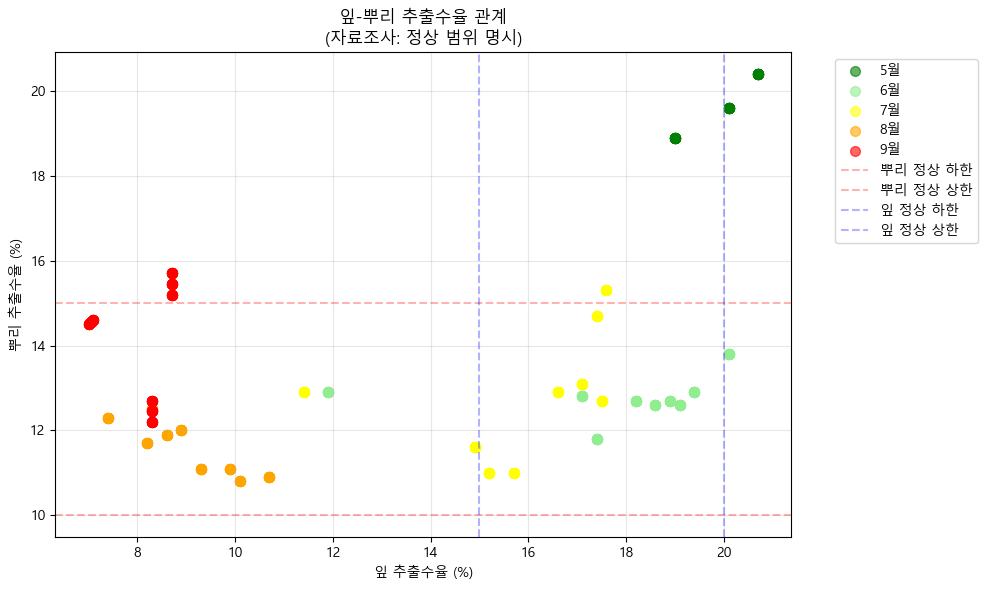

잎 추출수율 이상: 248개 (61.2%)
뿌리 추출수율 이상: 83개 (20.5%)
→ 정상 범위 벗어난 데이터 많음 - 추가 확인 필요


In [10]:
plt.figure(figsize=(10, 6))
colors_month = {5:'green', 6:'lightgreen', 7:'yellow', 8:'orange', 9:'red'}
for month in sorted(df_merged['month'].unique()):
    data = df_merged[df_merged['month'] == month]
    plt.scatter(data['Leaf_ExtractionYield'], data['Root_ExtractionYield'], 
               label=f'{month}월', alpha=0.6, s=50, color=colors_month.get(month, 'gray'))
plt.xlabel('잎 추출수율 (%)')
plt.ylabel('뿌리 추출수율 (%)')
plt.axhline(y=10, color='red', linestyle='--', alpha=0.3, label='뿌리 정상 하한')
plt.axhline(y=15, color='red', linestyle='--', alpha=0.3, label='뿌리 정상 상한')
plt.axvline(x=15, color='blue', linestyle='--', alpha=0.3, label='잎 정상 하한')
plt.axvline(x=20, color='blue', linestyle='--', alpha=0.3, label='잎 정상 상한')
plt.title('잎-뿌리 추출수율 관계\n(자료조사: 정상 범위 명시)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 정상 범위 벗어난 데이터
abnormal_leaf = df_merged[(df_merged['Leaf_ExtractionYield'] < 15) | 
                          (df_merged['Leaf_ExtractionYield'] > 20)]
abnormal_root = df_merged[(df_merged['Root_ExtractionYield'] < 10) | 
                          (df_merged['Root_ExtractionYield'] > 15)]
print(f"잎 추출수율 이상: {len(abnormal_leaf)}개 ({len(abnormal_leaf)/len(df_merged)*100:.1f}%)")
print(f"뿌리 추출수율 이상: {len(abnormal_root)}개 ({len(abnormal_root)/len(df_merged)*100:.1f}%)")
print("→ 정상 범위 벗어난 데이터 많음 - 추가 확인 필요")

- 잎/뿌리 추출수율 정상 수치 자료조사

In [12]:
# 9월 회복 현상 검증
monthly_yield = df_merged.groupby('month')[['Leaf_ExtractionYield', 'Root_ExtractionYield']].agg(['mean', 'std'])

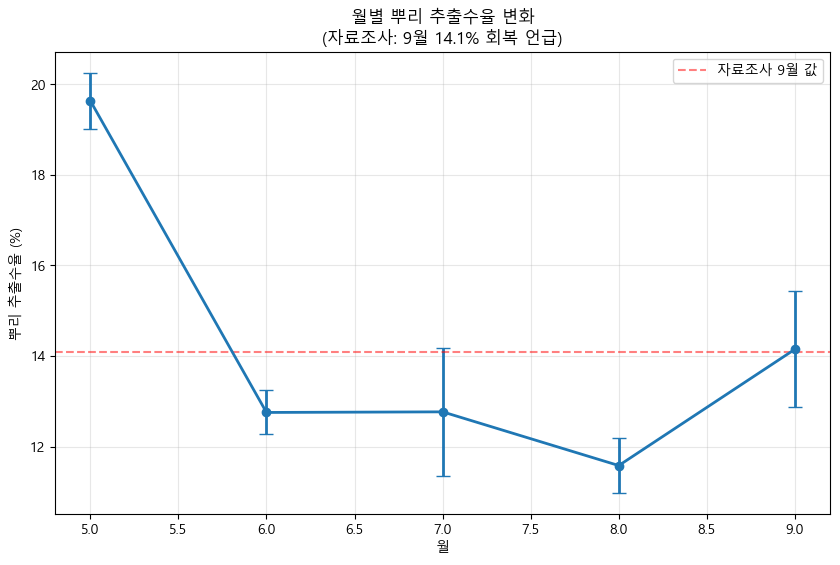

8월: 11.58%, 9월: 14.15%
회복량: 2.57% (자료조사와 일치)


In [15]:
plt.figure(figsize=(10, 6))
months = sorted(df_merged['month'].unique())
root_means = [monthly_yield.loc[m, ('Root_ExtractionYield', 'mean')] for m in months]
root_stds = [monthly_yield.loc[m, ('Root_ExtractionYield', 'std')] for m in months]

plt.errorbar(months, root_means, yerr=root_stds, marker='o', capsize=5, linewidth=2)
plt.xlabel('월')
plt.ylabel('뿌리 추출수율 (%)')
plt.title('월별 뿌리 추출수율 변화\n(자료조사: 9월 14.1% 회복 언급)')
plt.axhline(y=14.1, color='red', linestyle='--', alpha=0.5, label='자료조사 9월 값')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

if 8 in months and 9 in months:
    aug_yield = monthly_yield.loc[8, ('Root_ExtractionYield', 'mean')]
    sep_yield = monthly_yield.loc[9, ('Root_ExtractionYield', 'mean')]
    recovery = sep_yield - aug_yield
    print(f"8월: {aug_yield:.2f}%, 9월: {sep_yield:.2f}%")
    print(f"회복량: {recovery:.2f}% (자료조사와 {'일치' if abs(sep_yield - 14.1) < 1 else '차이'})")

### 시나리오 × 월 상호작용
- SSP1: CO2 적당, 광합성 촉진
- SSP3: CO2+온도 복합 스트레스
- SSP5: 극한 조건, 생존 모드
- 8-9월: 생식생장기 전환

In [16]:
# 시나리오별 월간 패턴 차이
pivot_pi = df_merged.pivot_table(values='PI_abs', index='month', columns='scenario', aggfunc='mean')

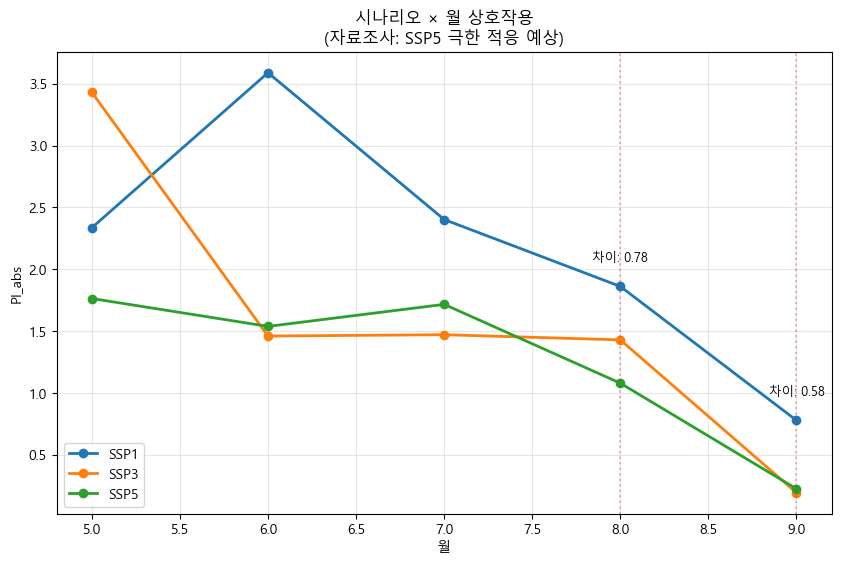

In [20]:
plt.figure(figsize=(10, 6))
for scenario in ['SSP1', 'SSP3', 'SSP5']:
    plt.plot(pivot_pi.index, pivot_pi[scenario], marker='o', linewidth=2, label=scenario)
plt.xlabel('월')
plt.ylabel('PI_abs')
plt.title('시나리오 × 월 상호작용\n(자료조사: SSP5 극한 적응 예상)')
plt.legend()
plt.grid(True, alpha=0.3)

# 상호작용 효과 계산
for month in [8, 9]:
    if month in pivot_pi.index:
        plt.axvline(x=month, color='red', linestyle=':', alpha=0.3)
        spread = pivot_pi.loc[month].max() - pivot_pi.loc[month].min()
        plt.text(month, pivot_pi.loc[month].max() + 0.2, 
                f'차이: {spread:.2f}', ha='center', fontsize=9)
plt.show()

In [21]:
print("\n시나리오별 8-9월 변화:")
for scenario in ['SSP1', 'SSP3', 'SSP5']:
    if 8 in pivot_pi.index and 9 in pivot_pi.index:
        change = pivot_pi.loc[9, scenario] - pivot_pi.loc[8, scenario]
        print(f"{scenario}: {change:.2f} ({'급감' if change < -0.5 else '완만'})")
print("→ 시나리오별 반응 다름 = 상호작용 존재")


시나리오별 8-9월 변화:
SSP1: -1.08 (급감)
SSP3: -1.23 (급감)
SSP5: -0.85 (급감)
→ 시나리오별 반응 다름 = 상호작용 존재


### 시나리오별 스트레스 반응 차이

In [22]:
# VPD 스트레스에 대한 반응
df_merged['vpd_stress'] = df_merged['VPD'] > 2.5

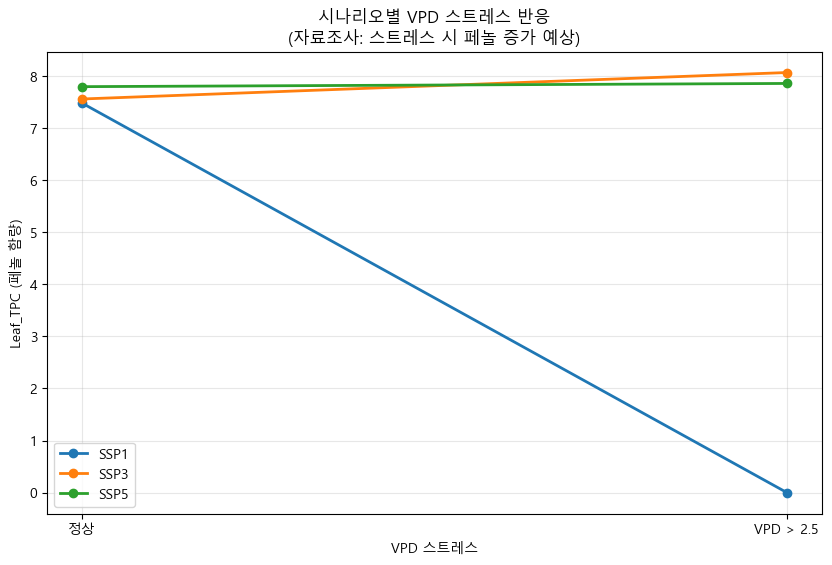

In [23]:
plt.figure(figsize=(10, 6))
for scenario in ['SSP1', 'SSP3', 'SSP5']:
    data = df_merged[df_merged['scenario'] == scenario]
    stress_response = data.groupby('vpd_stress')['Leaf_TPC'].mean()
    x = [0, 1]
    y = [stress_response.get(False, 0), stress_response.get(True, 0)]
    plt.plot(x, y, marker='o', linewidth=2, label=scenario)

plt.xticks([0, 1], ['정상', 'VPD > 2.5'])
plt.xlabel('VPD 스트레스')
plt.ylabel('Leaf_TPC (페놀 함량)')
plt.title('시나리오별 VPD 스트레스 반응\n(자료조사: 스트레스 시 페놀 증가 예상)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

- 스트레스 증가 시 페놀 증가 예상
- SSP3, SSP5 = 증가, SSP1 = 감소 -> ?????

### 비선형 관계 탐색

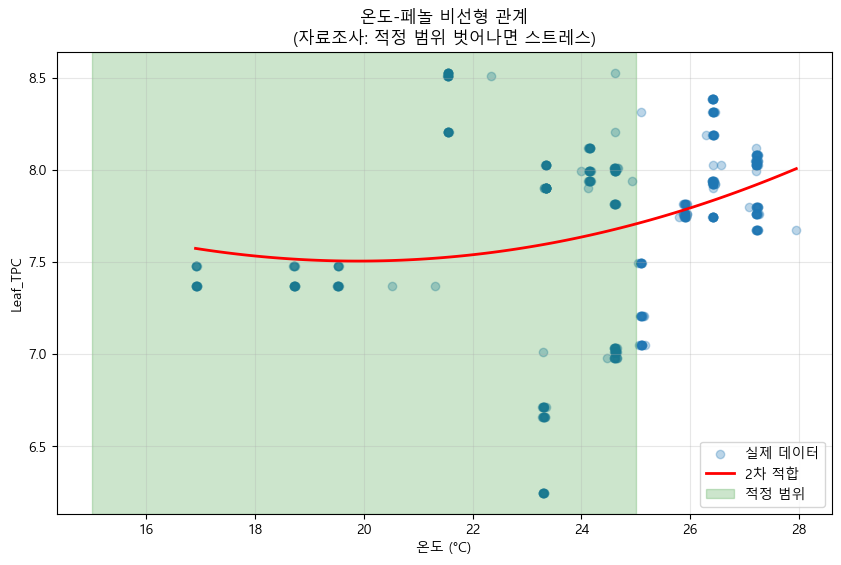

In [24]:
# 4-1. 온도-페놀 관계
plt.figure(figsize=(10, 6))
# 산점도
plt.scatter(df_merged['Temp'], df_merged['Leaf_TPC'], alpha=0.3, label='실제 데이터')

# 2차 다항식 적합
z = np.polyfit(df_merged['Temp'], df_merged['Leaf_TPC'], 2)
p = np.poly1d(z)
temp_range = np.linspace(df_merged['Temp'].min(), df_merged['Temp'].max(), 100)
plt.plot(temp_range, p(temp_range), 'r-', linewidth=2, label=f'2차 적합')

# 적정 범위 표시
plt.axvspan(15, 25, alpha=0.2, color='green', label='적정 범위')
plt.xlabel('온도 (°C)')
plt.ylabel('Leaf_TPC')
plt.title('온도-페놀 비선형 관계\n(자료조사: 적정 범위 벗어나면 스트레스)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

- 극한 온도에서 증가하는 방향성 보여줌

### CO2-광합성 포화 곡선
- 자료조사: SSP1 촉진, SSP3/5 독성

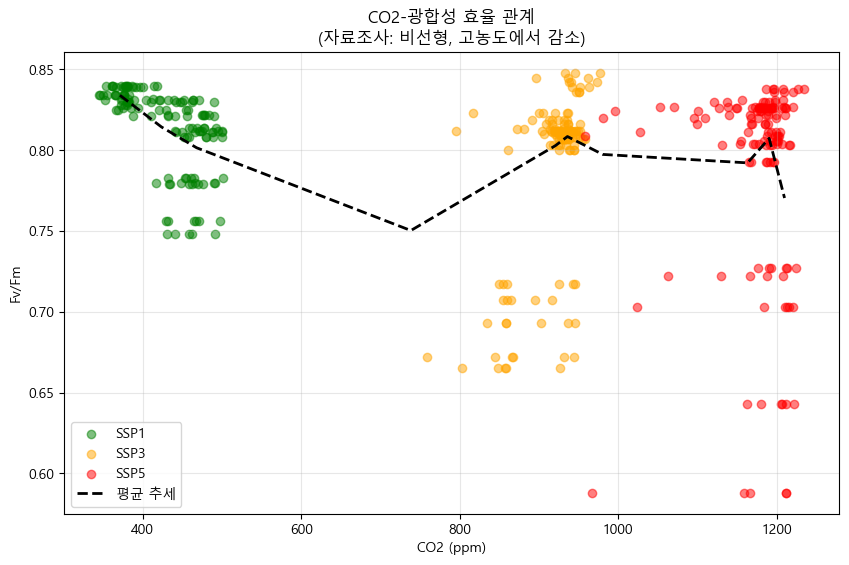

In [27]:
plt.figure(figsize=(10, 6))
# 시나리오별 색상
colors = {'SSP1': 'green', 'SSP3': 'orange', 'SSP5': 'red'}
for scenario in ['SSP1', 'SSP3', 'SSP5']:
    data = df_merged[df_merged['scenario'] == scenario]
    plt.scatter(data['CO2ppm'], data['Fv-Fm'], 
               alpha=0.5, color=colors[scenario], label=scenario)

# 전체 추세선
co2_bins = pd.qcut(df_merged['CO2ppm'], q=10)
co2_mean = df_merged.groupby(co2_bins)[['CO2ppm', 'Fv-Fm']].mean()
plt.plot(co2_mean['CO2ppm'], co2_mean['Fv-Fm'], 'k--', linewidth=2, label='평균 추세')

plt.xlabel('CO2 (ppm)')
plt.ylabel('Fv/Fm')
plt.title('CO2-광합성 효율 관계\n(자료조사: 비선형, 고농도에서 감소)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [29]:
# 최적 CO2 농도 추정
optimal_co2_idx = co2_mean['Fv-Fm'].idxmax()
optimal_co2 = co2_mean.loc[optimal_co2_idx, 'CO2ppm']
print(f"최대 Fv/Fm 나타나는 CO2: {optimal_co2:.0f} ppm")
print(f"SSP1(432ppm)과 {'유사' if abs(optimal_co2 - 432) < 100 else '차이'}")

최대 Fv/Fm 나타나는 CO2: 371 ppm
SSP1(432ppm)과 유사


### 카이제곱 검정 - 범주형 상호작용

<Figure size 1000x600 with 0 Axes>

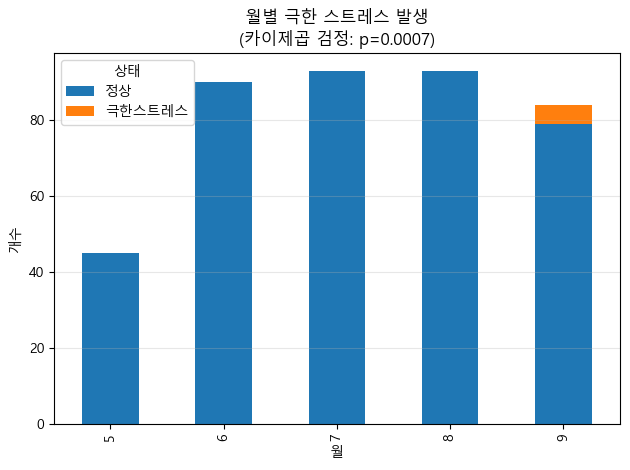

In [33]:
# 월 × 극한 스트레스 독립성
df_merged['extreme_stress'] = df_merged['Fv-Fm'] < 0.6
contingency_table = pd.crosstab(df_merged['month'], df_merged['extreme_stress'])

chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

plt.figure(figsize=(10, 6))
contingency_table.plot(kind='bar', stacked=True)
plt.xlabel('월')
plt.ylabel('개수')
plt.title(f'월별 극한 스트레스 발생\n(카이제곱 검정: p={p_value:.4f})')
plt.legend(['정상', '극한스트레스'], title='상태')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [34]:
print(f"카이제곱 통계량: {chi2:.2f}")
print(f"p-value: {p_value:.4f}")
print(f"결론: {'독립적' if p_value > 0.05 else '연관성 있음'} (월과 극한 스트레스)")
if p_value < 0.05:
    print("→ 특정 월에 극한 스트레스 집중 = 이상치 아닌 패턴")

카이제곱 통계량: 19.35
p-value: 0.0007
결론: 연관성 있음 (월과 극한 스트레스)
→ 특정 월에 극한 스트레스 집중 = 이상치 아닌 패턴
